In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk

In [1]:
parties = ["DUI", "SDSM", "Left", "VMRO-DPMNE"]
parties_csv_name = ["DUI.csv", "meta-ad-library-2025-04-30_2-SDSM.csv", "meta-ad-library-2025-04-30_3-Левица.csv", "meta-ad-library-2025-04-30-VMRO-DPMNE.csv"]
parties_csv_name_dict = {
    "DUI": "DUI.csv",
    "SDSM": "meta-ad-library-2025-04-30_2-SDSM.csv",
    "Left": "meta-ad-library-2025-04-30_3-Левица.csv",
    "VMRO-DPMNE": "meta-ad-library-2025-04-30-VMRO-DPMNE.csv"
}

In [37]:
read_dataset_path = "./dataset/"
save_images_path = "./figures/"

dui_df = pd.read_csv(read_dataset_path + parties_csv_name_dict["DUI"])
sdsm_df = pd.read_csv(read_dataset_path + parties_csv_name_dict["SDSM"])
left_df = pd.read_csv(read_dataset_path + parties_csv_name_dict["Left"])
vmro_df = pd.read_csv(read_dataset_path + parties_csv_name_dict["VMRO-DPMNE"])

dui_df['party'] = "DUI"
sdsm_df['party'] = "SDSM"
left_df['party'] = "Left"
vmro_df['party'] = "VMRO-DPMNE"

df = pd.concat([dui_df, sdsm_df, left_df, vmro_df], ignore_index=True)


# Clean and process numeric columns
def parse_bound(value):
    if pd.isna(value) or value == "":
        return np.nan
    try:
        return float(value.split(':')[-1].replace(',', '').strip())
    except:
        return np.nan

df['impressions_lower'] = df['impressions'].apply(lambda x: parse_bound(x))
df['impressions_upper'] = df['impressions'].apply(lambda x: parse_bound(x.split('upper_bound:')[-1]) if pd.notna(x) else np.nan)
df['spend_lower'] = df['spend'].apply(lambda x: parse_bound(x))
df['spend_upper'] = df['spend'].apply(lambda x: parse_bound(x.split('upper_bound:')[-1]) if pd.notna(x) else np.nan)

# Calculate midpoints for visualization
df['impressions_mid'] = (df['impressions_lower'] + df['impressions_upper']) / 2
df['spend_mid'] = (df['spend_lower'] + df['spend_upper']) / 2

<Figure size 1400x700 with 0 Axes>

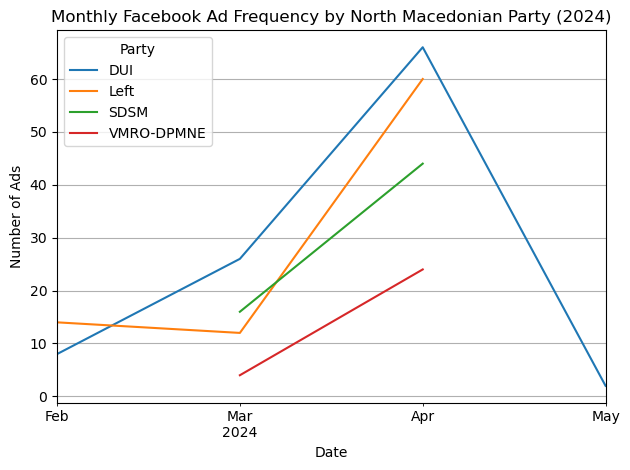

In [38]:
# Convert date columns
df['ad_creation_time'] = pd.to_datetime(df['ad_creation_time'])

plt.figure(figsize=(14, 7))
df.groupby([df['ad_creation_time'].dt.to_period('M'), 'party']).size().unstack().plot()
plt.title('Monthly Facebook Ad Frequency by North Macedonian Party (2024)')
plt.ylabel('Number of Ads')
plt.xlabel('Date')
plt.legend(title='Party')
plt.grid(True)
plt.tight_layout()
plt.savefig(save_images_path + "monthly_ad_frequency.png")
plt.show()


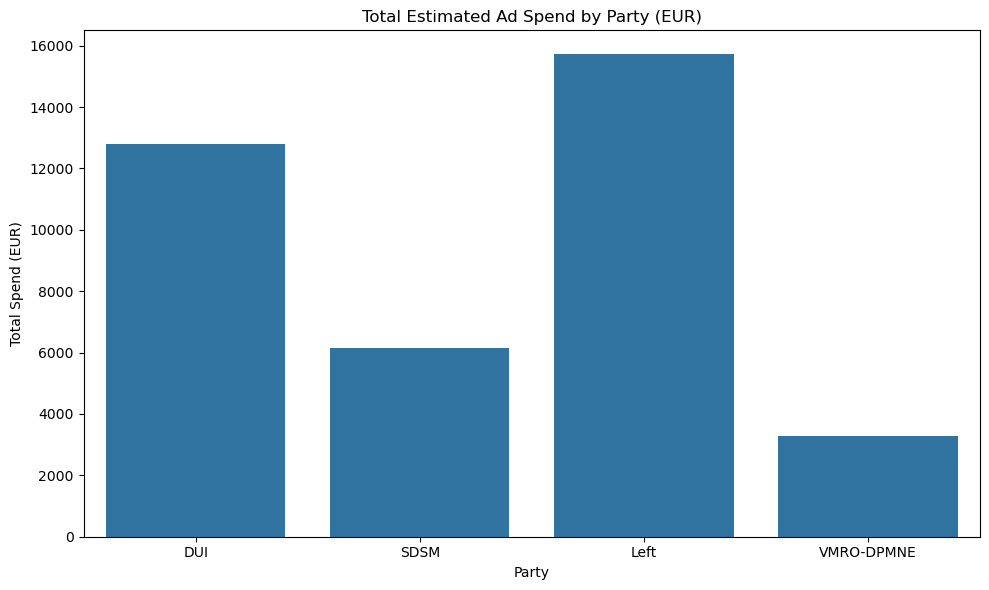

In [39]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df.groupby('party')['spend_mid'].sum().reset_index(), 
            x='party', y='spend_mid',
            order=["DUI", "SDSM", "Left", "VMRO-DPMNE"])
plt.title('Total Estimated Ad Spend by Party (EUR)')
plt.ylabel('Total Spend (EUR)')
plt.xlabel('Party')
plt.tight_layout()
plt.savefig(save_images_path + "total_spend_by_party.png")
plt.show()

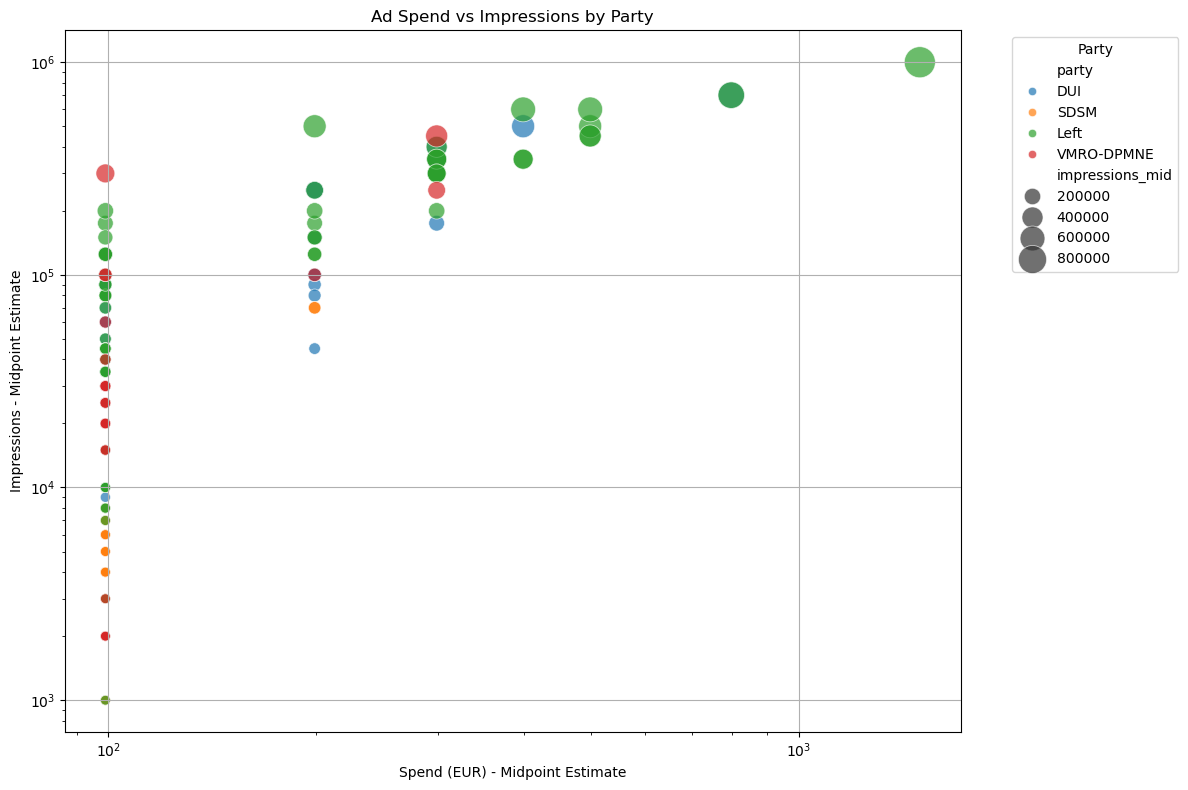

In [40]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='spend_mid', y='impressions_mid', hue='party',
               size='impressions_mid', sizes=(50, 500),
               hue_order=["DUI", "SDSM", "Left", "VMRO-DPMNE"],
               alpha=0.7)
plt.title('Ad Spend vs Impressions by Party')
plt.xlabel('Spend (EUR) - Midpoint Estimate')
plt.ylabel('Impressions - Midpoint Estimate')
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig(save_images_path + "spend_vs_impressions.png")
plt.show()

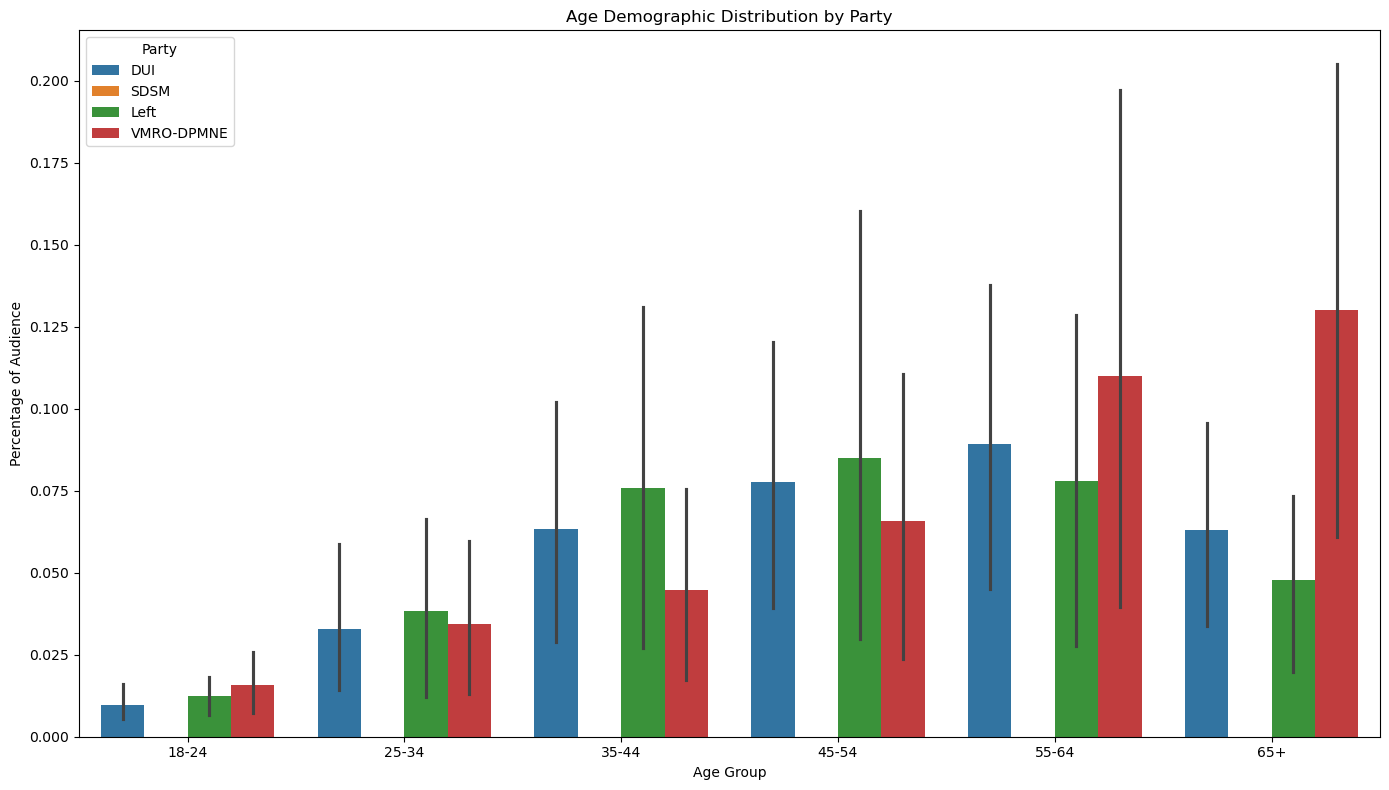

In [41]:
# Parse demographic data
def parse_demographics(x):
    try:
        return ast.literal_eval(x) if pd.notna(x) else []
    except:
        return []

df['demographics'] = df['demographic_distribution'].apply(parse_demographics)
df_demo = df.explode('demographics')

# Extract demo data
df_demo['age'] = df_demo['demographics'].apply(lambda x: x.get('age') if isinstance(x, dict) else None)
df_demo['gender'] = df_demo['demographics'].apply(lambda x: x.get('gender') if isinstance(x, dict) else None)
df_demo['percentage'] = df_demo['demographics'].apply(lambda x: x.get('percentage') if isinstance(x, dict) else None)

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(data=df_demo.dropna(), x='age', y='percentage', hue='party',
           order=['18-24', '25-34', '35-44', '45-54', '55-64', '65+'],
           hue_order=["DUI", "SDSM", "Left", "VMRO-DPMNE"])
plt.title('Age Demographic Distribution by Party')
plt.xlabel('Age Group')
plt.ylabel('Percentage of Audience')
plt.legend(title='Party')
plt.tight_layout()
plt.savefig(save_images_path + "age_demographics.png")
plt.show()

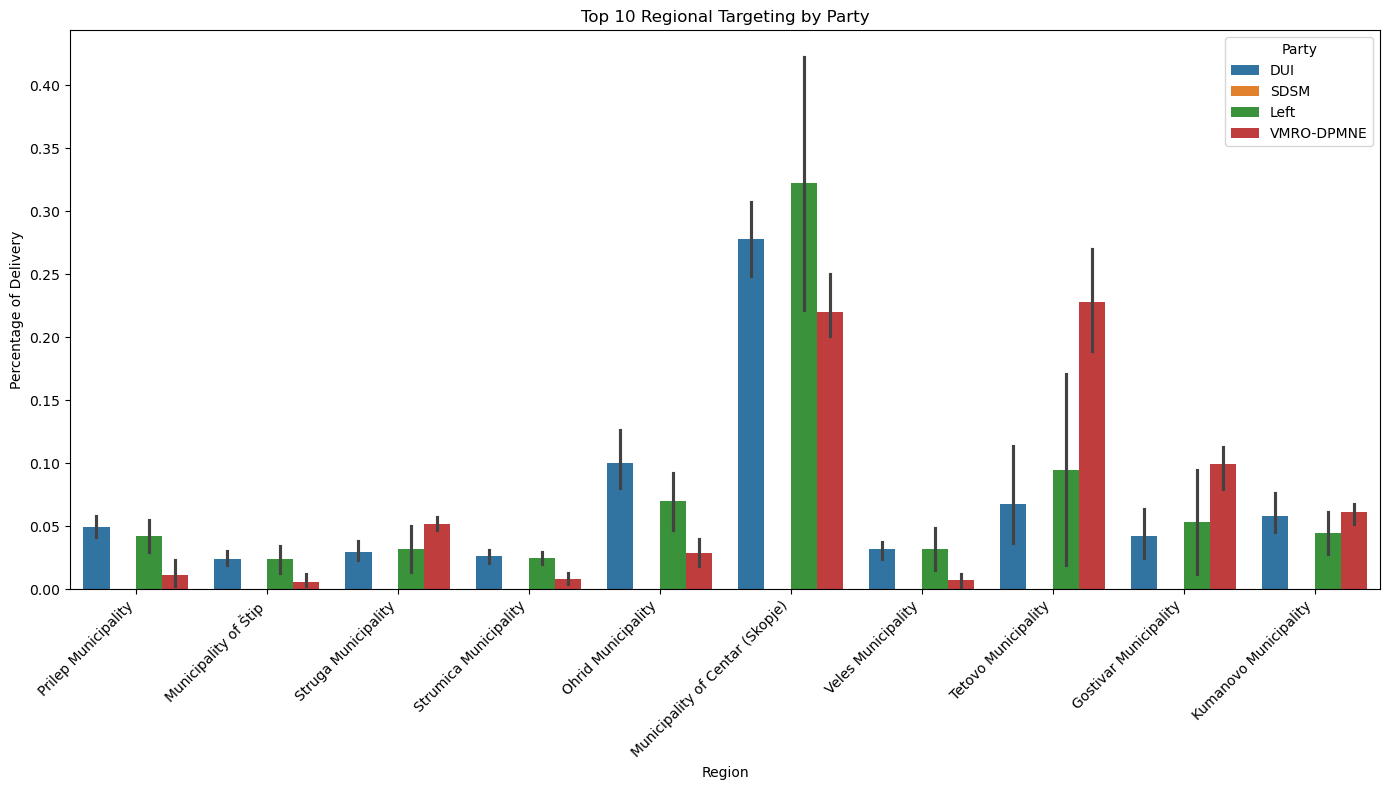

In [42]:
# Parse region data
df['regions'] = df['delivery_by_region'].apply(parse_demographics)
df_regions = df.explode('regions')

# Extract region data
df_regions['region'] = df_regions['regions'].apply(lambda x: x.get('region') if isinstance(x, dict) else None)
df_regions['region_pct'] = df_regions['regions'].apply(lambda x: x.get('percentage') if isinstance(x, dict) else None)

# Get top 10 regions overall
top_regions = df_regions.groupby('region')['region_pct'].sum().nlargest(10).index

plt.figure(figsize=(14, 8))
sns.barplot(data=df_regions[df_regions['region'].isin(top_regions)].dropna(),
            x='region', y='region_pct', hue='party',
            hue_order=["DUI", "SDSM", "Left", "VMRO-DPMNE"])
plt.title('Top 10 Regional Targeting by Party')
plt.xlabel('Region')
plt.ylabel('Percentage of Delivery')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Party')
plt.tight_layout()
plt.savefig(save_images_path + "top_regions.png")
plt.show()

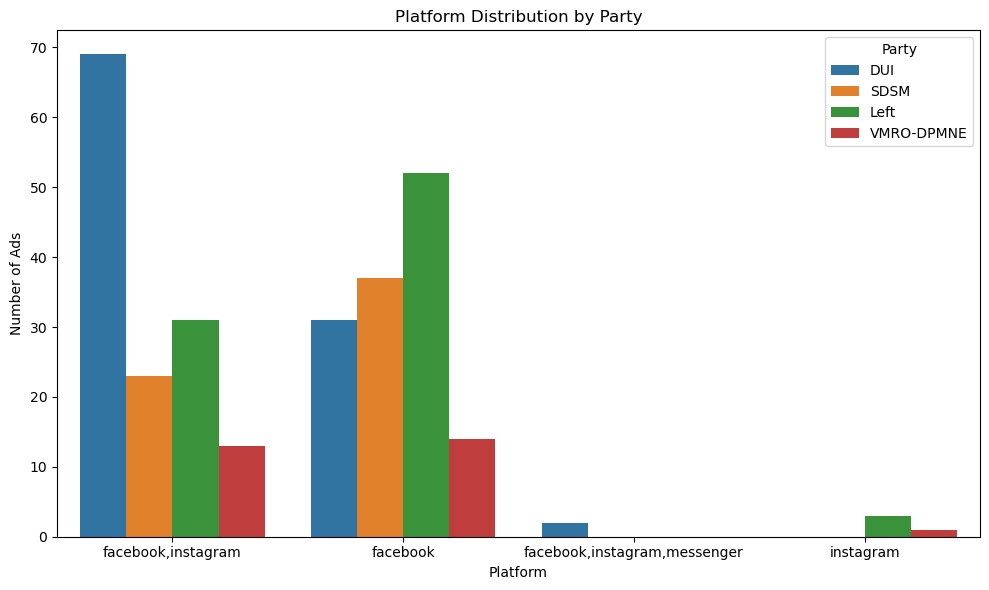

In [43]:
# Parse platforms
df['platforms'] = df['publisher_platforms'].str.strip('[]').str.replace("'", "").str.split(', ')
df_platforms = df.explode('platforms')

plt.figure(figsize=(10, 6))
sns.countplot(data=df_platforms, x='platforms', hue='party',
             hue_order=["DUI", "SDSM", "Left", "VMRO-DPMNE"])
plt.title('Platform Distribution by Party')
plt.xlabel('Platform')
plt.ylabel('Number of Ads')
plt.legend(title='Party')
plt.tight_layout()
plt.savefig(save_images_path + "platform_distribution.png")
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Harkeerat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


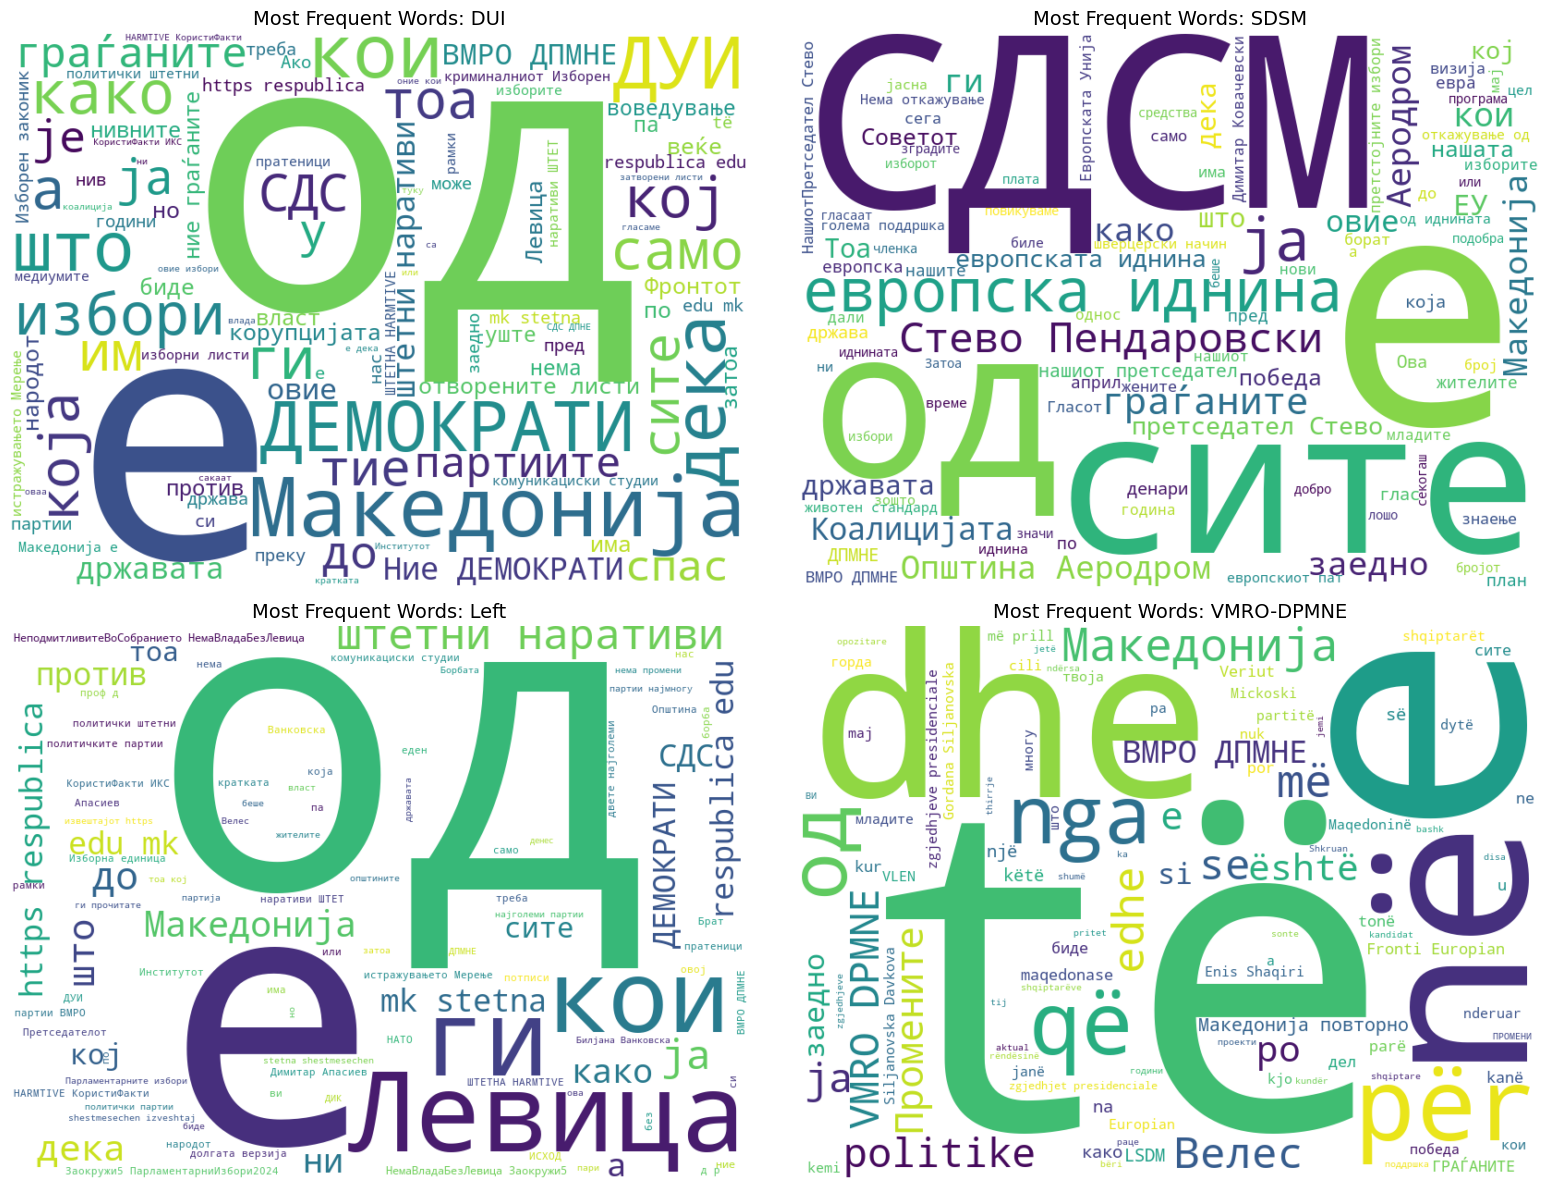

In [44]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# Add Macedonian stopwords
stop_words.update(['и', 'во', 'на', 'се', 'за', 'со', 'не', 'ќе', 'го', 'да'])

parties = ["DUI", "SDSM", "Left", "VMRO-DPMNE"]
plt.figure(figsize=(16, 12))

for i, party in enumerate(parties, 1):
    text = ' '.join(df[df['party'] == party]['ad_creative_bodies'].dropna().astype(str))
    
    wordcloud = WordCloud(width=800, height=600,
                         background_color='white',
                         stopwords=stop_words,
                         max_words=100).generate(text)
    
    plt.subplot(2, 2, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Frequent Words: {party}', fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.savefig(save_images_path + "wordclouds.png")
plt.show()